**Install PySpark**

In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285387 sha256=b63b0db75e49dc328c03788582c1bb295b17cb141c879d7d4e7d929537a064b3
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("SalesAnalysis").getOrCreate()

**Loading the data from google drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install openpyxl

In [ ]:
path = "/content/drive/MyDrive/Surge Global/DS_DE Internship - GS Sales Data 2022.v2.xlsx"

In [ ]:
import pandas as pd
from pandas import ExcelFile
df = pd.ExcelFile('/content/drive/MyDrive/Surge Global/DS_DE Internship - GS Sales Data 2022.v2.xlsx', engine ='openpyxl')
print(df)

In [ ]:
df.sheet_names

['Task', 'GS Sales Data', 'Daily Target']

*Load GS Sales Data Sheet*

In [ ]:
gs_sales_df = df.parse("GS Sales Data")
display(gs_sales_df.head(5))

,Row ID,Order ID,Order Date,Order_Week,Ship Date,Ship_Week,Ship Mode,Customer ID,Customer Name,Segment,...,Regional Manager,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Returned
0,1,US-2019-103800,2019-01-03,2019-1,2019-01-07,2019-2,Standard Class,DP-13000,Darren Powers,Consumer,...,Roxanne Rodriguez,OFF-PA-10000174,Office Supplies,Paper,"Message Book, Wirebound, Four 5 1/2"" X 4"" Form...",16.448,2,0.2,5.5512,NaN
1,2,US-2019-112326,2019-01-04,2019-1,2019-01-08,2019-2,Standard Class,PO-19195,Phillina Ober,Home Office,...,Roxanne Rodriguez,OFF-BI-10004094,Office Supplies,Binders,GBC Standard Plastic Binding Systems Combs,3.540,2,0.8,-5.4870,NaN
2,3,US-2019-112326,2019-01-04,2019-1,2019-01-08,2019-2,Standard Class,PO-19195,Phillina Ober,Home Office,...,Roxanne Rodriguez,OFF-LA-10003223,Office Supplies,Labels,Avery 508,11.784,3,0.2,4.2717,NaN
3,4,US-2019-112326,2019-01-04,2019-1,2019-01-08,2019-2,Standard Class,PO-19195,Phillina Ober,Home Office,...,Roxanne Rodriguez,OFF-ST-10002743,Office Supplies,Storage,SAFCO Boltless Steel Shelving,272.736,3,0.2,-64.7748,NaN
4,5,US-2019-141817,2019-01-05,2019-1,2019-01-12,2019-2,Standard Class,MB-18085,Mick Brown,Consumer,...,Chuck Magee,OFF-AR-10003478,Office Supplies,Art,Avery Hi-Liter EverBold Pen Style Fluorescent ...,19.536,3,0.2,4.8840,NaN


In [ ]:
gs_sales_df = spark.createDataFrame(gs_sales_df)
display(gs_sales_df)

DataFrame[Row ID: bigint, Order ID: string, Order Date: timestamp, Order_Week: string, Ship Date: timestamp, Ship_Week: string, Ship Mode: string, Customer ID: string, Customer Name: string, Segment: string, Country/Region: string, City: string, State/Province: string, Postal Code: string, Region: string, Regional Manager: string, Product ID: string, Category: string, Sub-Category: string, Product Name: string, Sales: double, Quantity: bigint, Discount: double, Profit: double, Returned: string]

*Load Daily target Sheet*

In [ ]:
target_df = df.parse("Daily Target")
display(target_df.head(5))

,Category,Order Date,Segment,Sales Target
0,Office Supplies,2019-01-03,Consumer,15
1,Office Supplies,2019-01-04,Home Office,300
2,Office Supplies,2019-01-05,Consumer,21
3,Furniture,2019-01-06,Home Office,2316
4,Office Supplies,2019-01-06,Consumer,17


In [ ]:
target_df = spark.createDataFrame(target_df)
display(target_df)

DataFrame[Category: string, Order Date: timestamp, Segment: string, Sales Target: bigint]

Join the two dataframes

In [ ]:
sales_df = gs_sales_df.join(target_df, on=['Category', 'Order Date', 'Segment'], how='left')
sales_df.show()

+---------------+-------------------+-----------+------+--------------+----------+-------------------+---------+--------------+-----------+----------------+--------------+-------------+--------------+-----------+-------+-----------------+---------------+------------+--------------------+------------------+--------+--------+-------------------+--------+------------+
|       Category|         Order Date|    Segment|Row ID|      Order ID|Order_Week|          Ship Date|Ship_Week|     Ship Mode|Customer ID|   Customer Name|Country/Region|         City|State/Province|Postal Code| Region| Regional Manager|     Product ID|Sub-Category|        Product Name|             Sales|Quantity|Discount|             Profit|Returned|Sales Target|
+---------------+-------------------+-----------+------+--------------+----------+-------------------+---------+--------------+-----------+----------------+--------------+-------------+--------------+-----------+-------+-----------------+---------------+----------

In [ ]:
sales_df.count()

10200

In [ ]:
#check the duplicates
print(sales_df.count())
sales_df = sales_df.dropDuplicates()
print(sales_df.count())

10200
10200


**Schema Verification**

In [ ]:
sales_df.printSchema()

root
 |-- Category: string (nullable = true)
 |-- Order Date: timestamp (nullable = true)
 |-- Segment: string (nullable = true)
 |-- Row ID: long (nullable = true)
 |-- Order ID: string (nullable = true)
 |-- Order_Week: string (nullable = true)
 |-- Ship Date: timestamp (nullable = true)
 |-- Ship_Week: string (nullable = true)
 |-- Ship Mode: string (nullable = true)
 |-- Customer ID: string (nullable = true)
 |-- Customer Name: string (nullable = true)
 |-- Country/Region: string (nullable = true)
 |-- City: string (nullable = true)
 |-- State/Province: string (nullable = true)
 |-- Postal Code: string (nullable = true)
 |-- Region: string (nullable = true)
 |-- Regional Manager: string (nullable = true)
 |-- Product ID: string (nullable = true)
 |-- Sub-Category: string (nullable = true)
 |-- Product Name: string (nullable = true)
 |-- Sales: double (nullable = true)
 |-- Quantity: long (nullable = true)
 |-- Discount: double (nullable = true)
 |-- Profit: double (nullable = true)

In [ ]:
from pyspark.sql.functions import to_date

sales_df = sales_df.withColumn("Row ID",sales_df['Row ID'].cast("Integer"))
sales_df = sales_df.withColumn("Quantity",sales_df['Quantity'].cast("Integer"))
sales_df = sales_df.withColumn("Sales target",sales_df['Sales target'].cast("Integer"))
sales_df = sales_df.withColumn("Order Date", to_date(sales_df["Order Date"]))
sales_df = sales_df.withColumn("Ship Date", to_date(sales_df["Ship Date"]))

In [ ]:
sales_df.printSchema()

root
 |-- Category: string (nullable = true)
 |-- Order Date: date (nullable = true)
 |-- Segment: string (nullable = true)
 |-- Row ID: integer (nullable = true)
 |-- Order ID: string (nullable = true)
 |-- Order_Week: string (nullable = true)
 |-- Ship Date: date (nullable = true)
 |-- Ship_Week: string (nullable = true)
 |-- Ship Mode: string (nullable = true)
 |-- Customer ID: string (nullable = true)
 |-- Customer Name: string (nullable = true)
 |-- Country/Region: string (nullable = true)
 |-- City: string (nullable = true)
 |-- State/Province: string (nullable = true)
 |-- Postal Code: string (nullable = true)
 |-- Region: string (nullable = true)
 |-- Regional Manager: string (nullable = true)
 |-- Product ID: string (nullable = true)
 |-- Sub-Category: string (nullable = true)
 |-- Product Name: string (nullable = true)
 |-- Sales: double (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- Discount: double (nullable = true)
 |-- Profit: double (nullable = true)
 |-

**Creating the fact and dimension tables**


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_timestamp
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, TimestampType, DoubleType, DateType

# Schema for Customer
dim_customer_schema = StructType([
    StructField("Customer ID", StringType(), True, metadata={"primaryKey": True}),
    StructField("Customer Name", StringType(), True),
    StructField("Segment", StringType(), True),
])

dim_customer_df = sales_df.select(
    col("Customer ID"),
    col("Customer Name"),
    col("Segment")
)

In [ ]:
from pyspark.sql.functions import monotonically_increasing_id

# Schema for Country
dim_country_schema = StructType([
    StructField("Country/Region", StringType(), True),
    StructField("CountryID", IntegerType(), True, metadata={"primaryKey": True}),
    StructField("City", StringType(), True),
    StructField("State/Province", StringType(), True),
    StructField("Postal Code", StringType(), True),
    StructField("Region", StringType(), True),
    StructField("Regional manager", StringType(), True),
])

dim_country_df = sales_df.select(
    col("Country/Region"),
    col("City"),
    col("State/Province"),
    col("Postal Code"),
    col("Region"),
    col("Regional Manager")
).distinct().withColumn("CountryID", monotonically_increasing_id() + 1)

In [ ]:
# Schema for Ship Mode
dim_ship_mode_schema = StructType([
    StructField("Ship Mode", StringType(), True, metadata={"primaryKey": True}),
    StructField("ShipID", IntegerType(), True),
])

dim_ship_mode_df = sales_df.select(
    col("Ship Mode")
).distinct().withColumn("ShipID", monotonically_increasing_id() + 1)

In [ ]:
# Schema for Product
dim_product_schema = StructType([
    StructField("Product ID", StringType(), True, metadata={"primaryKey": True}),
    StructField("Category", StringType(), True),
    StructField("Sub-Category", StringType(), True),
    StructField("Product Name", StringType(), True),
])

dim_product_df = sales_df.select(
    col("Product ID"),
    col("Category"),
    col("Sub-Category"),
    col("Product Name")
)

In [ ]:
from pyspark.sql.functions import col, date_format, weekofyear, month, year

# Schema for Calender
dim_calendar_schema = StructType([
    StructField("Date", DateType(), True, metadata={"primaryKey": True}),
    StructField("DayName", StringType(), True),
    StructField("WeekNumber", IntegerType(), True),
    StructField("MonthNumber", IntegerType(), True),
    StructField("MonthName", StringType(), True),
    StructField("Year", IntegerType(), True),
])

# Select the unique Order Date and Ship Date values from the original DataFrame
order_dates_df = sales_df.select(col("Order Date").alias("Date")).distinct()
ship_dates_df = sales_df.select(col("Ship Date").alias("Date")).distinct()

#get a unique list of dates
unique_dates_df = order_dates_df.union(ship_dates_df)

dim_calendar_df = unique_dates_df.withColumn("DayName", date_format(col("Date"), "EEEE"))
dim_calendar_df = dim_calendar_df.withColumn("WeekNumber", weekofyear(col("Date")))
dim_calendar_df = dim_calendar_df.withColumn("MonthNumber", month(col("Date")))
dim_calendar_df = dim_calendar_df.withColumn("MonthName", date_format(col("Date"), "MMMM"))
dim_calendar_df = dim_calendar_df.withColumn("Year", year(col("Date")))

In [ ]:
# Define the fact table schema
fact_schema = StructType([
    StructField("Row ID", IntegerType(), True, metadata={"primaryKey": True}),
    StructField("Order ID", StringType(), True),
    StructField("Order Date", TimestampType(), True, metadata={"foreignKey": True}),
    StructField("Ship Date", TimestampType(), True, metadata={"foreignKey": True}),
    StructField("Customer ID", StringType(), True, metadata={"foreignKey": True}),
    StructField("CountryID", IntegerType(), True, metadata={"foreignKey": True}),
    StructField("Product ID", StringType(), True, metadata={"foreignKey": True}),
    StructField("Sales", DoubleType(), True),
    StructField("Quantity", IntegerType(), True),
    StructField("Discount", DoubleType(), True),
    StructField("Profit", DoubleType(), True),
    StructField("Returned", StringType(), True),
    StructField("Sales target", IntegerType(), True),
    StructField("ShipID", IntegerType(), True, metadata={"foreignKey": True}),
])

fact_df = sales_df.join(
    dim_country_df.select("Country/Region", "CountryID"),
    sales_df["Country/Region"] == dim_country_df["Country/Region"],
    "left"
).join(
    dim_ship_mode_df.select("Ship Mode", "ShipID"),
    sales_df["Ship Mode"] == dim_ship_mode_df["Ship Mode"],
    "left"
).select(
    col("Row ID"),
    col("Order ID"),
    col("Order Date"),
    col("Ship Date"),
    col("Customer ID"),
    col("CountryID"),
    col("Product ID"),
    col("Sales"),
    col("Quantity"),
    col("Discount"),
    col("Profit"),
    col("Returned"),
    col("Sales target"),
    col("ShipID")
)

In [ ]:
print("Customer")
dim_customer_df.printSchema()
dim_customer_df.show(20)

print("Country")
dim_country_df.printSchema()
dim_country_df.show(20)

print("Ship Mode")
dim_ship_mode_df.printSchema()
dim_ship_mode_df.show(20)

print("Product")
dim_product_df.printSchema()
dim_product_df.show(20)

print("Calender")
dim_calendar_df.printSchema()
dim_calendar_df.show(20)

print("fact")
fact_df.show(20)

Customer
root
 |-- Customer ID: string (nullable = true)
 |-- Customer Name: string (nullable = true)
 |-- Segment: string (nullable = true)

+-----------+-------------------+-----------+
|Customer ID|      Customer Name|    Segment|
+-----------+-------------------+-----------+
|   CS-12250|    Chris Selesnick|  Corporate|
|   CS-12250|    Chris Selesnick|  Corporate|
|   CS-12250|    Chris Selesnick|  Corporate|
|   CS-12250|    Chris Selesnick|  Corporate|
|   MS-17365|Maribeth Schnelling|   Consumer|
|   LC-17140|       Logan Currie|   Consumer|
|   CC-12220|       Chris Cortes|   Consumer|
|   RP-19270|       Rachel Payne|  Corporate|
|   AH-10030|      Aaron Hawkins|  Corporate|
|   NL-18310|     Nancy Lomonaco|Home Office|
|   BP-11095|       Bart Pistole|  Corporate|
|   BP-11095|       Bart Pistole|  Corporate|
|   SP-20620|   Stefania Perrino|  Corporate|
|   SP-20620|   Stefania Perrino|  Corporate|
|   RL-19615|          Rob Lucas|   Consumer|
|   RL-19615|          Rob Luc

Removing Duplicates

In [ ]:
print(dim_customer_df.count())
print(dim_ship_mode_df.count())
print(dim_product_df.count())
print(dim_country_df.count())

dim_customer_df = dim_customer_df.dropDuplicates()
dim_ship_mode_df = dim_ship_mode_df.dropDuplicates()
dim_product_df = dim_product_df.dropDuplicates()
dim_country_df = dim_country_df.dropDuplicates()

print(dim_customer_df.count())
print(dim_ship_mode_df.count())
print(dim_product_df.count())
print(dim_country_df.count())

10200
4
10200
696
826
4
1917
696


**Augment/Enrich the data**

Calculating the unit product price

In [ ]:
sales_df = sales_df.withColumn("Product Price", (col("Sales") / (1 - col("Discount"))) / col("Quantity"))
sales_df.show(5)

+---------------+----------+---------+------+--------------+----------+----------+---------+--------------+-----------+-------------------+--------------+------------+--------------+-----------+-------+-----------------+---------------+------------+--------------------+------------------+--------+--------+------------------+--------+------------+-------------+
|       Category|Order Date|  Segment|Row ID|      Order ID|Order_Week| Ship Date|Ship_Week|     Ship Mode|Customer ID|      Customer Name|Country/Region|        City|State/Province|Postal Code| Region| Regional Manager|     Product ID|Sub-Category|        Product Name|             Sales|Quantity|Discount|            Profit|Returned|Sales target|Product Price|
+---------------+----------+---------+------+--------------+----------+----------+---------+--------------+-----------+-------------------+--------------+------------+--------------+-----------+-------+-----------------+---------------+------------+--------------------+----

Calculating the quantity requared for target sales

In [ ]:
sales_df = sales_df.withColumn("Quantity Required", col("Sales target") / (col("Product Price") - (col("Product Price")*col("Discount"))))
sales_df.show(5)

+---------------+----------+---------+------+--------------+----------+----------+---------+--------------+-----------+-------------------+--------------+------------+--------------+-----------+-------+-----------------+---------------+------------+--------------------+------------------+--------+--------+------------------+--------+------------+-------------+------------------+
|       Category|Order Date|  Segment|Row ID|      Order ID|Order_Week| Ship Date|Ship_Week|     Ship Mode|Customer ID|      Customer Name|Country/Region|        City|State/Province|Postal Code| Region| Regional Manager|     Product ID|Sub-Category|        Product Name|             Sales|Quantity|Discount|            Profit|Returned|Sales target|Product Price| Quantity Required|
+---------------+----------+---------+------+--------------+----------+----------+---------+--------------+-----------+-------------------+--------------+------------+--------------+-----------+-------+-----------------+---------------+

**Handling Missing Values**

In [ ]:
# for i in sales_df.columns:
#   count = sales_df.filter(col(i).isNull() | (col(i) == "NaN")).count()
#   print(f"{i}: {count}")

from pyspark.sql.functions import count, when, col

def missing_values_cal():
  nulls = sales_df.select([count(when(col(i).isNull() | (col(i) == "NaN"), i)).alias(i) for i in sales_df.columns])
  nulls.show()

In [ ]:
missing_values_cal()

+--------+----------+-------+------+--------+----------+---------+---------+---------+-----------+-------------+--------------+----+--------------+-----------+------+----------------+----------+------------+------------+-----+--------+--------+------+--------+------------+-------------+-----------------+
|Category|Order Date|Segment|Row ID|Order ID|Order_Week|Ship Date|Ship_Week|Ship Mode|Customer ID|Customer Name|Country/Region|City|State/Province|Postal Code|Region|Regional Manager|Product ID|Sub-Category|Product Name|Sales|Quantity|Discount|Profit|Returned|Sales target|Product Price|Quantity Required|
+--------+----------+-------+------+--------+----------+---------+---------+---------+-----------+-------------+--------------+----+--------------+-----------+------+----------------+----------+------------+------------+-----+--------+--------+------+--------+------------+-------------+-----------------+
|      24|         0|      0|     0|       0|         0|        0|        0|      

Handling missing values in Customer Column mapping with Customer ID

In [ ]:
from pyspark.sql.functions import first

#By selecting the first non-null value of Customer Name
customer_name_fill = (
    sales_df
    .groupBy('Customer ID')
    .agg(first(col('Customer Name')).alias('CustomerName'))
    .na.drop()
)

sales_df = sales_df.join(customer_name_fill, on='Customer ID', how='left')
sales_df = sales_df.drop('Customer Name')
sales_df = sales_df.withColumnRenamed('CustomerName', 'Customer Name')

In [ ]:
sales_df.show(5)

+-----------+---------------+----------+---------+------+--------------+----------+----------+---------+--------------+--------------+------------+--------------+-----------+-------+-----------------+---------------+------------+--------------------+------------------+--------+--------+------------------+--------+------------+-------------+------------------+-------------------+
|Customer ID|       Category|Order Date|  Segment|Row ID|      Order ID|Order_Week| Ship Date|Ship_Week|     Ship Mode|Country/Region|        City|State/Province|Postal Code| Region| Regional Manager|     Product ID|Sub-Category|        Product Name|             Sales|Quantity|Discount|            Profit|Returned|Sales target|Product Price| Quantity Required|      Customer Name|
+-----------+---------------+----------+---------+------+--------------+----------+----------+---------+--------------+--------------+------------+--------------+-----------+-------+-----------------+---------------+------------+-------

In [ ]:
missing_values_cal()

+-----------+--------+----------+-------+------+--------+----------+---------+---------+---------+--------------+----+--------------+-----------+------+----------------+----------+------------+------------+-----+--------+--------+------+--------+------------+-------------+-----------------+-------------+
|Customer ID|Category|Order Date|Segment|Row ID|Order ID|Order_Week|Ship Date|Ship_Week|Ship Mode|Country/Region|City|State/Province|Postal Code|Region|Regional Manager|Product ID|Sub-Category|Product Name|Sales|Quantity|Discount|Profit|Returned|Sales target|Product Price|Quantity Required|Customer Name|
+-----------+--------+----------+-------+------+--------+----------+---------+---------+---------+--------------+----+--------------+-----------+------+----------------+----------+------------+------------+-----+--------+--------+------+--------+------------+-------------+-----------------+-------------+
|          0|      24|         0|      0|     0|       0|         0|        0|    

In [ ]:
sales_df.createOrReplaceTempView("sales_view")

In [ ]:
query = """
SELECT `Customer ID`, `Customer Name`
FROM sales_view
WHERE isnan(`Customer Name`)
"""

result = spark.sql(query)
result.show()

+-----------+-------------+
|Customer ID|Customer Name|
+-----------+-------------+
+-----------+-------------+



Handling missing values in Returned Column

In [ ]:
sales_df = sales_df.withColumn("Returned", when(sales_df["Returned"] == 'NaN', "Pending").otherwise(sales_df["Returned"]))
sales_df.show(5)

+-----------+---------------+----------+---------+------+--------------+----------+----------+---------+--------------+--------------+------------+--------------+-----------+-------+-----------------+---------------+------------+--------------------+------------------+--------+--------+------------------+--------+------------+-------------+------------------+-------------------+
|Customer ID|       Category|Order Date|  Segment|Row ID|      Order ID|Order_Week| Ship Date|Ship_Week|     Ship Mode|Country/Region|        City|State/Province|Postal Code| Region| Regional Manager|     Product ID|Sub-Category|        Product Name|             Sales|Quantity|Discount|            Profit|Returned|Sales target|Product Price| Quantity Required|      Customer Name|
+-----------+---------------+----------+---------+------+--------------+----------+----------+---------+--------------+--------------+------------+--------------+-----------+-------+-----------------+---------------+------------+-------

In [ ]:
missing_values_cal()

+-----------+--------+----------+-------+------+--------+----------+---------+---------+---------+--------------+----+--------------+-----------+------+----------------+----------+------------+------------+-----+--------+--------+------+--------+------------+-------------+-----------------+-------------+
|Customer ID|Category|Order Date|Segment|Row ID|Order ID|Order_Week|Ship Date|Ship_Week|Ship Mode|Country/Region|City|State/Province|Postal Code|Region|Regional Manager|Product ID|Sub-Category|Product Name|Sales|Quantity|Discount|Profit|Returned|Sales target|Product Price|Quantity Required|Customer Name|
+-----------+--------+----------+-------+------+--------+----------+---------+---------+---------+--------------+----+--------------+-----------+------+----------------+----------+------------+------------+-----+--------+--------+------+--------+------------+-------------+-----------------+-------------+
|          0|      24|         0|      0|     0|       0|         0|        0|    

Handling missing values in Regional Manager column mapping with Region

In [ ]:
regional_manager_fill = (
    sales_df
    .groupBy('Region')
    .agg(first(col('Regional Manager')).alias('RegionalManager'))
    .na.drop()
)

sales_df = sales_df.join(regional_manager_fill, on='Region', how='left')
sales_df = sales_df.drop('Regional Manager')
sales_df = sales_df.withColumnRenamed('RegionalManager', 'Regional Manager')

sales_df.show(5)

+-------+-----------+---------------+----------+---------+------+--------------+----------+----------+---------+--------------+--------------+------------+--------------+-----------+---------------+------------+--------------------+------------------+--------+--------+------------------+--------+------------+-------------+------------------+-------------------+-----------------+
| Region|Customer ID|       Category|Order Date|  Segment|Row ID|      Order ID|Order_Week| Ship Date|Ship_Week|     Ship Mode|Country/Region|        City|State/Province|Postal Code|     Product ID|Sub-Category|        Product Name|             Sales|Quantity|Discount|            Profit|Returned|Sales target|Product Price| Quantity Required|      Customer Name| Regional Manager|
+-------+-----------+---------------+----------+---------+------+--------------+----------+----------+---------+--------------+--------------+------------+--------------+-----------+---------------+------------+--------------------+----

In [ ]:
missing_values_cal()

+------+-----------+--------+----------+-------+------+--------+----------+---------+---------+---------+--------------+----+--------------+-----------+----------+------------+------------+-----+--------+--------+------+--------+------------+-------------+-----------------+-------------+----------------+
|Region|Customer ID|Category|Order Date|Segment|Row ID|Order ID|Order_Week|Ship Date|Ship_Week|Ship Mode|Country/Region|City|State/Province|Postal Code|Product ID|Sub-Category|Product Name|Sales|Quantity|Discount|Profit|Returned|Sales target|Product Price|Quantity Required|Customer Name|Regional Manager|
+------+-----------+--------+----------+-------+------+--------+----------+---------+---------+---------+--------------+----+--------------+-----------+----------+------------+------------+-----+--------+--------+------+--------+------------+-------------+-----------------+-------------+----------------+
|     0|          0|      24|         0|      0|     0|       0|         0|       

Handling missing values in State/Province column mapping with Postal Code

In [ ]:
state_fill = (
    sales_df
    .groupBy('Postal Code')
    .agg(first(col('State/Province')).alias('StateProvince'))
    .na.drop()
)

sales_df = sales_df.join(state_fill, on='Postal Code', how='left')
sales_df = sales_df.drop('State/Province')
sales_df = sales_df.withColumnRenamed('StateProvince', 'State/Province')

sales_df.show(5)

+-----------+-------+-----------+---------------+----------+---------+------+--------------+----------+----------+---------+--------------+--------------+------------+---------------+------------+--------------------+------------------+--------+--------+------------------+--------+------------+-------------+------------------+-------------------+-----------------+--------------+
|Postal Code| Region|Customer ID|       Category|Order Date|  Segment|Row ID|      Order ID|Order_Week| Ship Date|Ship_Week|     Ship Mode|Country/Region|        City|     Product ID|Sub-Category|        Product Name|             Sales|Quantity|Discount|            Profit|Returned|Sales target|Product Price| Quantity Required|      Customer Name| Regional Manager|State/Province|
+-----------+-------+-----------+---------------+----------+---------+------+--------------+----------+----------+---------+--------------+--------------+------------+---------------+------------+--------------------+------------------+

In [ ]:
missing_values_cal()

+-----------+------+-----------+--------+----------+-------+------+--------+----------+---------+---------+---------+--------------+----+----------+------------+------------+-----+--------+--------+------+--------+------------+-------------+-----------------+-------------+----------------+--------------+
|Postal Code|Region|Customer ID|Category|Order Date|Segment|Row ID|Order ID|Order_Week|Ship Date|Ship_Week|Ship Mode|Country/Region|City|Product ID|Sub-Category|Product Name|Sales|Quantity|Discount|Profit|Returned|Sales target|Product Price|Quantity Required|Customer Name|Regional Manager|State/Province|
+-----------+------+-----------+--------+----------+-------+------+--------+----------+---------+---------+---------+--------------+----+----------+------------+------------+-----+--------+--------+------+--------+------------+-------------+-----------------+-------------+----------------+--------------+
|          0|     0|          0|      24|         0|      0|     0|       0|      

Handling missing values in Category column mapping with Product ID

In [ ]:
distinct_product_id = sales_df.select("Product ID").distinct()
distinct_product_id.show()

+---------------+
|     Product ID|
+---------------+
|FUR-FU-10000409|
|OFF-AR-10003504|
|OFF-AP-10002495|
|FUR-CH-10003833|
|OFF-EN-10002600|
|OFF-PA-10002615|
|TEC-MA-10001047|
|FUR-CH-10000863|
|FUR-TA-10004086|
|OFF-PA-10001457|
|OFF-PA-10000575|
|OFF-LA-10004008|
|OFF-BI-10001636|
|OFF-PA-10001639|
|OFF-AR-10003876|
|OFF-ST-10003641|
|FUR-TA-10000849|
|OFF-PA-10004243|
|OFF-BI-10001575|
|OFF-AP-10001303|
+---------------+
only showing top 20 rows



In [ ]:
sales_df = sales_df.withColumn("Product Category", sales_df["Product ID"].substr(1, 3))

In [ ]:
sales_df.show(5)

+-----------+-------+-----------+---------------+----------+---------+------+--------------+----------+----------+---------+--------------+--------------+------------+---------------+------------+--------------------+------------------+--------+--------+------------------+--------+------------+-------------+------------------+-------------------+-----------------+--------------+----------------+
|Postal Code| Region|Customer ID|       Category|Order Date|  Segment|Row ID|      Order ID|Order_Week| Ship Date|Ship_Week|     Ship Mode|Country/Region|        City|     Product ID|Sub-Category|        Product Name|             Sales|Quantity|Discount|            Profit|Returned|Sales target|Product Price| Quantity Required|      Customer Name| Regional Manager|State/Province|Product Category|
+-----------+-------+-----------+---------------+----------+---------+------+--------------+----------+----------+---------+--------------+--------------+------------+---------------+------------+------

In [ ]:
distinct_product_category = sales_df.select("Product Category").distinct()
distinct_product_category.show()

+----------------+
|Product Category|
+----------------+
|             OFF|
|             TEC|
|             FUR|
+----------------+



Add a seperate column having category type

In [ ]:
sales_df = sales_df.withColumn("Category",
                   when((sales_df["Category"] == "NaN") & (sales_df["Product Category"] == "OFF"), "Office Supplies")
                   .when((sales_df["Category"]== "NaN") & (sales_df["Product Category"] == "TEC"), "Technology")
                   .when((sales_df["Category"]== "NaN") & (sales_df["Product Category"] == "FUR"), "Furniture")
                   .otherwise(sales_df["Category"]))

In [ ]:
missing_values_cal()

+-----------+------+-----------+--------+----------+-------+------+--------+----------+---------+---------+---------+--------------+----+----------+------------+------------+-----+--------+--------+------+--------+------------+-------------+-----------------+-------------+----------------+--------------+----------------+
|Postal Code|Region|Customer ID|Category|Order Date|Segment|Row ID|Order ID|Order_Week|Ship Date|Ship_Week|Ship Mode|Country/Region|City|Product ID|Sub-Category|Product Name|Sales|Quantity|Discount|Profit|Returned|Sales target|Product Price|Quantity Required|Customer Name|Regional Manager|State/Province|Product Category|
+-----------+------+-----------+--------+----------+-------+------+--------+----------+---------+---------+---------+--------------+----+----------+------------+------------+-----+--------+--------+------+--------+------------+-------------+-----------------+-------------+----------------+--------------+----------------+
|          0|     0|          0

In [ ]:
sales_df.show(5)

+-----------+-------+-----------+---------------+----------+---------+------+--------------+----------+----------+---------+--------------+--------------+----------+---------------+------------+--------------------+------------------+--------+--------+------------------+--------+------------+------------------+------------------+-------------+-----------------+--------------+----------------+
|Postal Code| Region|Customer ID|       Category|Order Date|  Segment|Row ID|      Order ID|Order_Week| Ship Date|Ship_Week|     Ship Mode|Country/Region|      City|     Product ID|Sub-Category|        Product Name|             Sales|Quantity|Discount|            Profit|Returned|Sales target|     Product Price| Quantity Required|Customer Name| Regional Manager|State/Province|Product Category|
+-----------+-------+-----------+---------------+----------+---------+------+--------------+----------+----------+---------+--------------+--------------+----------+---------------+------------+--------------

Handling missing values in the Sales target column by mean of sales target value

In [ ]:
from pyspark.sql.functions import mean
mean_sales_target = sales_df.select(mean(col('Sales target'))).collect()[0][0]
sales_df = sales_df.withColumn('Sales target', when(col('Sales target').isNull(), mean_sales_target).otherwise(col('Sales target')))

In [ ]:
missing_values_cal()

+-----------+------+-----------+--------+----------+-------+------+--------+----------+---------+---------+---------+--------------+----+----------+------------+------------+-----+--------+--------+------+--------+------------+-------------+-----------------+-------------+----------------+--------------+----------------+
|Postal Code|Region|Customer ID|Category|Order Date|Segment|Row ID|Order ID|Order_Week|Ship Date|Ship_Week|Ship Mode|Country/Region|City|Product ID|Sub-Category|Product Name|Sales|Quantity|Discount|Profit|Returned|Sales target|Product Price|Quantity Required|Customer Name|Regional Manager|State/Province|Product Category|
+-----------+------+-----------+--------+----------+-------+------+--------+----------+---------+---------+---------+--------------+----+----------+------------+------------+-----+--------+--------+------+--------+------------+-------------+-----------------+-------------+----------------+--------------+----------------+
|          0|     0|          0

In [ ]:
mean_sales_target = sales_df.select(mean(col('Quantity Required'))).collect()[0][0]
sales_df = sales_df.withColumn('Quantity Required', when(col('Quantity Required').isNull(), mean_sales_target).otherwise(col('Quantity Required')))

In [ ]:
missing_values_cal()

+-----------+------+-----------+--------+----------+-------+------+--------+----------+---------+---------+---------+--------------+----+----------+------------+------------+-----+--------+--------+------+--------+------------+-------------+-----------------+-------------+----------------+--------------+----------------+
|Postal Code|Region|Customer ID|Category|Order Date|Segment|Row ID|Order ID|Order_Week|Ship Date|Ship_Week|Ship Mode|Country/Region|City|Product ID|Sub-Category|Product Name|Sales|Quantity|Discount|Profit|Returned|Sales target|Product Price|Quantity Required|Customer Name|Regional Manager|State/Province|Product Category|
+-----------+------+-----------+--------+----------+-------+------+--------+----------+---------+---------+---------+--------------+----+----------+------------+------------+-----+--------+--------+------+--------+------------+-------------+-----------------+-------------+----------------+--------------+----------------+
|          0|     0|          0

In [ ]:
query = """
SELECT *
FROM sales_view
WHERE `Order Date` = '2019-01-04'
"""
result = spark.sql(query)
result.show()

+-----------+---------------+----------+-----------+------+--------------+----------+----------+---------+--------------+--------------+----------+--------------+-----------+-------+-----------------+---------------+------------+--------------------+-----------------+--------+--------+------------------+--------+------------+------------------+------------------+-------------+
|Customer ID|       Category|Order Date|    Segment|Row ID|      Order ID|Order_Week| Ship Date|Ship_Week|     Ship Mode|Country/Region|      City|State/Province|Postal Code| Region| Regional Manager|     Product ID|Sub-Category|        Product Name|            Sales|Quantity|Discount|            Profit|Returned|Sales target|     Product Price| Quantity Required|Customer Name|
+-----------+---------------+----------+-----------+------+--------------+----------+----------+---------+--------------+--------------+----------+--------------+-----------+-------+-----------------+---------------+------------+-----------

Analysing the Data

In [ ]:
sales_df.printSchema()

root
 |-- Postal Code: string (nullable = true)
 |-- Region: string (nullable = true)
 |-- Customer ID: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Order Date: date (nullable = true)
 |-- Segment: string (nullable = true)
 |-- Row ID: integer (nullable = true)
 |-- Order ID: string (nullable = true)
 |-- Order_Week: string (nullable = true)
 |-- Ship Date: date (nullable = true)
 |-- Ship_Week: string (nullable = true)
 |-- Ship Mode: string (nullable = true)
 |-- Country/Region: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Product ID: string (nullable = true)
 |-- Sub-Category: string (nullable = true)
 |-- Product Name: string (nullable = true)
 |-- Sales: double (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- Discount: double (nullable = true)
 |-- Profit: double (nullable = true)
 |-- Returned: string (nullable = true)
 |-- Sales target: double (nullable = true)
 |-- Product Price: double (nullable = true)
 |-- Quantity

In [ ]:
sales_df.describe().show()

+-------+------------------+-------+-----------+----------+-----------+-----------------+--------------+----------+---------+--------------+--------------+--------+---------------+------------+--------------------+-------------------+------------------+-------------------+------------------+--------+------------------+------------------+--------------------+------------------+----------------+--------------+----------------+
|summary|       Postal Code| Region|Customer ID|  Category|    Segment|           Row ID|      Order ID|Order_Week|Ship_Week|     Ship Mode|Country/Region|    City|     Product ID|Sub-Category|        Product Name|              Sales|          Quantity|           Discount|            Profit|Returned|      Sales target|     Product Price|   Quantity Required|     Customer Name|Regional Manager|State/Province|Product Category|
+-------+------------------+-------+-----------+----------+-----------+-----------------+--------------+----------+---------+--------------+--

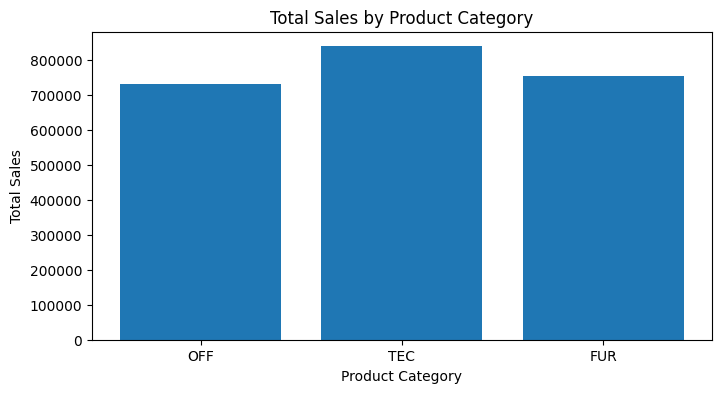

In [ ]:
import matplotlib.pyplot as plt

sales_by_category = sales_df.groupBy('Product Category').sum('Sales').toPandas()

plt.figure(figsize=(8, 4))
plt.bar(sales_by_category['Product Category'], sales_by_category['sum(Sales)'])
plt.xlabel('Product Category')
plt.ylabel('Total Sales')
plt.title('Total Sales by Product Category')
plt.show()

Most of the sales were obtained from the Technology category. Overall all the categories performes a higher total sales.

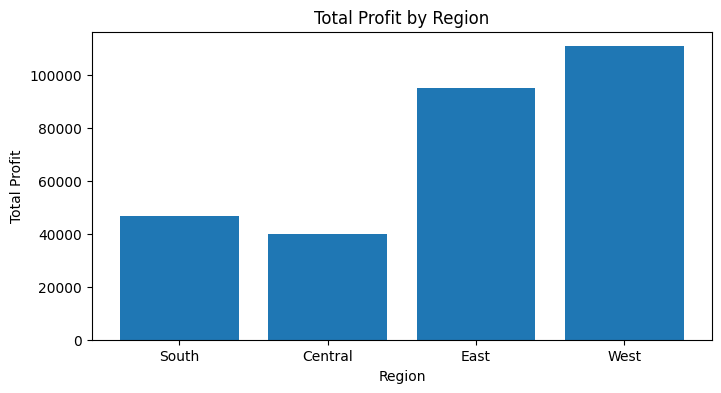

In [ ]:
profit_by_region = sales_df.groupBy('Region').sum('Profit').toPandas()

plt.figure(figsize=(8, 4))
plt.bar(profit_by_region['Region'], profit_by_region['sum(Profit)'])
plt.xlabel('Region')
plt.ylabel('Total Profit')
plt.title('Total Profit by Region')

plt.show()

The maximum total profit was gained in the West region while the minimum profit was gained by Central Province. The East region also gained a significant total progit but less than the total profit gained by the West resion

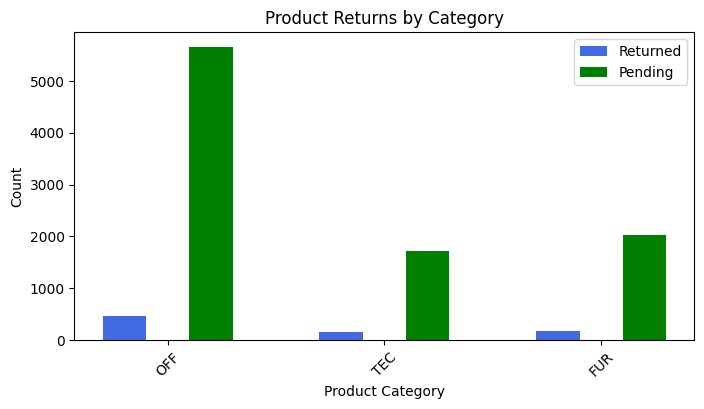

In [ ]:
import seaborn as sns

returned_df = sales_df.filter(sales_df["Returned"] == "Yes")
pending_df = sales_df.filter(sales_df["Returned"] == "Pending")

return_counts = returned_df.groupBy("Product Category").count().toPandas()
pending_counts = pending_df.groupBy("Product Category").count().toPandas()

plt.figure(figsize=(8, 4))
x = range(len(return_counts))
bar_width = 0.2

# Plot for Returned
plt.bar(x, return_counts['count'], width=bar_width, label='Returned', color='royalblue')

# Plot for Pending
if not pending_counts.empty:
    plt.bar([i + bar_width * 2 for i in x], pending_counts['count'], width=bar_width, label='Pending', color='green')

plt.xlabel('Product Category')
plt.ylabel('Count')
plt.title('Product Returns by Category')
plt.xticks([i + bar_width for i in x], return_counts['Product Category'], rotation=45)

plt.legend()
plt.show()

Office supplies products were returned more than Technology and the Furniture category. But he sales obtained by Furniture less than the other categories. So the reason may be that the product quality of furnitures.

In [ ]:
distinct_product_category = sales_df.select("Returned").distinct()
distinct_product_category.show()

+--------+
|Returned|
+--------+
|     Yes|
| Pending|
+--------+



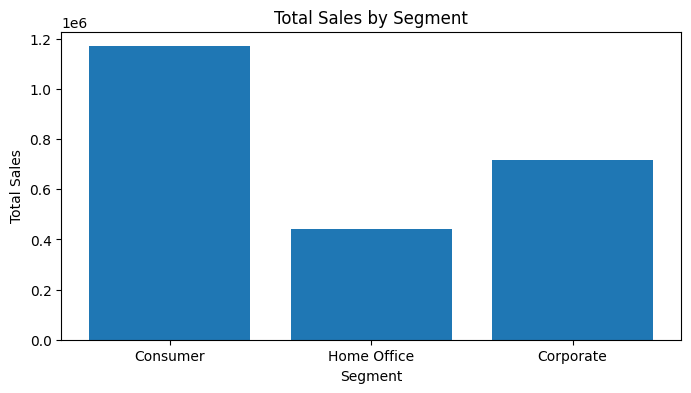

In [ ]:
sales_by_category = sales_df.groupBy('Segment').sum('Sales').toPandas()

plt.figure(figsize=(8, 4))
plt.bar(sales_by_category['Segment'], sales_by_category['sum(Sales)'])
plt.xlabel('Segment')
plt.ylabel('Total Sales')
plt.title('Total Sales by Segment')
plt.show()

Consumer segment has a higher total values that Home office segment and corporate segment. the least profit may also obtained by the home office segment

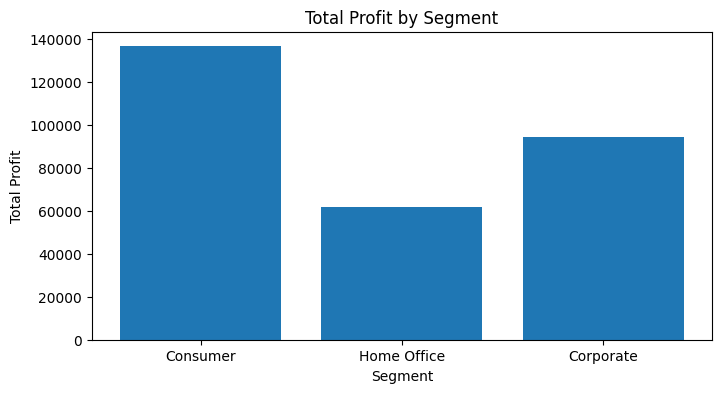

In [ ]:
profit_by_segment = sales_df.groupBy('Segment').sum('Profit').toPandas()

plt.figure(figsize=(8, 4))
plt.bar(profit_by_segment['Segment'], profit_by_segment['sum(Profit)'])
plt.xlabel('Segment')
plt.ylabel('Total Profit')
plt.title('Total Profit by Segment')

plt.show()

Consumer segment has a higher demand and achieved total profit more than home office segment and corporate segments

Building the model

In [ ]:
sales_df.show()

+-----------+-------+-----------+---------------+----------+-----------+------+--------------+----------+----------+---------+--------------+--------------+----------------+---------------+------------+--------------------+------------------+--------+--------+-------------------+--------+------------+------------------+------------------+-------------------+-----------------+--------------+----------------+
|Postal Code| Region|Customer ID|       Category|Order Date|    Segment|Row ID|      Order ID|Order_Week| Ship Date|Ship_Week|     Ship Mode|Country/Region|            City|     Product ID|Sub-Category|        Product Name|             Sales|Quantity|Discount|             Profit|Returned|Sales target|     Product Price| Quantity Required|      Customer Name| Regional Manager|State/Province|Product Category|
+-----------+-------+-----------+---------------+----------+-----------+------+--------------+----------+----------+---------+--------------+--------------+----------------+-----

In [ ]:
for i in sales_df.columns:
  print(f"{i} : {sales_df.select(i).distinct().count()}")

Postal Code : 654
Region : 4
Customer ID : 804
Category : 3
Order Date : 1242
Segment : 3
Row ID : 10194
Order ID : 5111
Order_Week : 212
Ship Date : 1338
Ship_Week : 212
Ship Mode : 4
Country/Region : 2
City : 542
Product ID : 1862
Sub-Category : 17
Product Name : 1849
Sales : 6161
Quantity : 14
Discount : 12
Profit : 7597
Returned : 2
Sales target : 1342
Product Price : 1775
Quantity Required : 9831
Customer Name : 800
Regional Manager : 4
State/Province : 59
Product Category : 3


In [ ]:
#roundoff the values
from pyspark.sql.functions import round
sales_df = sales_df.withColumn("Profit", round(sales_df["Profit"], 3))
sales_df = sales_df.withColumn("Sales", round(sales_df["Sales"], 3))
sales_df = sales_df.withColumn("Product Price", round(sales_df["Product Price"], 3))
sales_df = sales_df.withColumn("Quantity Required", round(col("Quantity Required"), 1).cast("integer"))

In [ ]:
sales_df.show(5)

+-----------+-------+-----------+---------------+----------+---------+------+--------------+----------+----------+---------+--------------+--------------+------------+---------------+------------+--------------------+------+--------+--------+------+--------+------------+-------------+-----------------+-------------------+-----------------+--------------+----------------+
|Postal Code| Region|Customer ID|       Category|Order Date|  Segment|Row ID|      Order ID|Order_Week| Ship Date|Ship_Week|     Ship Mode|Country/Region|        City|     Product ID|Sub-Category|        Product Name| Sales|Quantity|Discount|Profit|Returned|Sales target|Product Price|Quantity Required|      Customer Name| Regional Manager|State/Province|Product Category|
+-----------+-------+-----------+---------------+----------+---------+------+--------------+----------+----------+---------+--------------+--------------+------------+---------------+------------+--------------------+------+--------+--------+------+---

In [ ]:
columns_to_drop = ['Row ID', 'Order ID', 'Product Name', 'Customer ID', 'Customer Name', 'Regional Manager','Postal Code', 'Order Date', 'Ship Date', 'Product ID']
sales_df = sales_df.drop(*columns_to_drop)

In [ ]:
sales_df.show(5)

+-------+---------------+---------+----------+---------+--------------+--------------+----------+------------+-------+--------+--------+------+--------+------------+-------------+-----------------+--------------+----------------+
| Region|       Category|  Segment|Order_Week|Ship_Week|     Ship Mode|Country/Region|      City|Sub-Category|  Sales|Quantity|Discount|Profit|Returned|Sales target|Product Price|Quantity Required|State/Province|Product Category|
+-------+---------------+---------+----------+---------+--------------+--------------+----------+------------+-------+--------+--------+------+--------+------------+-------------+-----------------+--------------+----------------+
|Central|Office Supplies|Corporate|   2021-26|  2021-26|Standard Class| United States|Carrollton|       Paper| 10.368|       2|     0.2| 3.629| Pending|        52.0|         6.48|               10|         Texas|             OFF|
|Central|      Furniture| Consumer|   2019-46|  2019-47|Standard Class| United S

In [ ]:
from pyspark.sql.functions import split

sales_df = sales_df.withColumn("Year", split(col("Order_Week"), "-")[0].cast("integer"))
sales_df = sales_df.withColumn("Order Week", split(col("Order_Week"), "-")[1].cast("integer"))

sales_df = sales_df.withColumn("Ship Week", split(col("Ship_Week"), "-")[1].cast("integer"))

sales_df = sales_df.drop('Order_Week')
sales_df = sales_df.drop('Ship_Week')
sales_df = sales_df.drop('City')
sales_df = sales_df.drop('State/Province')
sales_df.show(5)

+-------+---------------+---------+--------------+--------------+------------+------+--------+--------+------+--------+------------+-------------+-----------------+----------------+----+----------+---------+
| Region|       Category|  Segment|     Ship Mode|Country/Region|Sub-Category| Sales|Quantity|Discount|Profit|Returned|Sales target|Product Price|Quantity Required|Product Category|Year|Order Week|Ship Week|
+-------+---------------+---------+--------------+--------------+------------+------+--------+--------+------+--------+------------+-------------+-----------------+----------------+----+----------+---------+
|  South|Office Supplies|Corporate|  Second Class| United States|     Binders|  5.64|       3|     0.0| 2.707| Pending|       570.0|         1.88|              303|             OFF|2019|         3|        3|
|  South|Office Supplies|Corporate|  Second Class| United States|   Envelopes| 50.94|       3|     0.0| 25.47| Pending|       570.0|        16.98|               33|    

In [ ]:
sales_df = sales_df.withColumn("Year", col("Year").cast("double"))
sales_df = sales_df.withColumn("Quantity", col("Quantity").cast("double"))
sales_df = sales_df.withColumn("Order Week", col("Order Week").cast("double"))
sales_df = sales_df.withColumn("Ship Week", col("Ship Week").cast("double"))

In [ ]:
columns_to_drop = ['Order ID', 'Product Name', 'Customer ID', 'Customer Name', 'Regional Manager','Postal Code', 'Order Date', 'Ship Date', 'Product ID']
sales_df = sales_df.drop(*columns_to_drop)

In [ ]:
sales_df.printSchema()

root
 |-- Region: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Segment: string (nullable = true)
 |-- Ship Mode: string (nullable = true)
 |-- Country/Region: string (nullable = true)
 |-- Sub-Category: string (nullable = true)
 |-- Sales: double (nullable = true)
 |-- Quantity: double (nullable = true)
 |-- Discount: double (nullable = true)
 |-- Profit: double (nullable = true)
 |-- Returned: string (nullable = true)
 |-- Sales target: double (nullable = true)
 |-- Product Price: double (nullable = true)
 |-- Quantity Required: integer (nullable = true)
 |-- Product Category: string (nullable = true)
 |-- Year: double (nullable = true)
 |-- Order Week: double (nullable = true)
 |-- Ship Week: double (nullable = true)



In [ ]:
missing_values_cal()

+------+--------+-------+---------+--------------+------------+-----+--------+--------+------+--------+------------+-------------+-----------------+----------------+----+----------+---------+
|Region|Category|Segment|Ship Mode|Country/Region|Sub-Category|Sales|Quantity|Discount|Profit|Returned|Sales target|Product Price|Quantity Required|Product Category|Year|Order Week|Ship Week|
+------+--------+-------+---------+--------------+------------+-----+--------+--------+------+--------+------------+-------------+-----------------+----------------+----+----------+---------+
|     0|       0|      0|        0|             0|           0|    0|       0|       0|     0|       0|           0|            0|                0|               0|   0|         0|        0|
+------+--------+-------+---------+--------------+------------+-----+--------+--------+------+--------+------------+-------------+-----------------+----------------+----+----------+---------+



Defining the categorical columns and te numerical columns

In [ ]:
catCols = [x for (x, dataType) in sales_df.dtypes if dataType == "string"]
numCols = [
    x for (x, dataType) in sales_df.dtypes if ((x != "Quantity Required") & (dataType == "double" or dataType == "integer"))
]

In [ ]:
print(catCols)
print(numCols)

['Region', 'Category', 'Segment', 'Ship Mode', 'Country/Region', 'Sub-Category', 'Returned', 'Product Category']
['Sales', 'Quantity', 'Discount', 'Profit', 'Sales target', 'Product Price', 'Year', 'Order Week', 'Ship Week']


In [ ]:
from pyspark.ml.feature import(
    OneHotEncoder,
    StringIndexer
)

Indexing categorical string columns into unique numerical indices

In [ ]:
string_indexer = [
    StringIndexer(inputCol=x, outputCol=x + "_StringIndexer", handleInvalid="skip")
    for x in catCols
]

In [ ]:
string_indexer

[StringIndexer_b2dcb2c36374,
 StringIndexer_53bf37aba286,
 StringIndexer_363e7d652012,
 StringIndexer_f845f3389c5f,
 StringIndexer_e77503e203c7,
 StringIndexer_d91e1411d769,
 StringIndexer_0cb5101c0b8d,
 StringIndexer_05f0718d2748]

Unique numerical indices convert into a binary format

In [ ]:
one_hot_encoder = [
    OneHotEncoder(
        inputCols= [f"{x}_StringIndexer" for x in catCols],
        outputCols=[f"{x}_OneHotEncoder" for x in catCols],
    )
]

In [ ]:
one_hot_encoder

[OneHotEncoder_2a730940c0b7]

In [ ]:
from pyspark.ml.feature import VectorAssembler

Combine multiple input columns into a single vector colum

In [ ]:
assemblerInput = [x for x in numCols]
assemblerInput += [f"{x}_OneHotEncoder" for x in catCols]

In [ ]:
assemblerInput

['Sales',
 'Quantity',
 'Discount',
 'Profit',
 'Sales target',
 'Product Price',
 'Year',
 'Order Week',
 'Ship Week',
 'Region_OneHotEncoder',
 'Category_OneHotEncoder',
 'Segment_OneHotEncoder',
 'Ship Mode_OneHotEncoder',
 'Country/Region_OneHotEncoder',
 'Sub-Category_OneHotEncoder',
 'Returned_OneHotEncoder',
 'Product Category_OneHotEncoder']

In [ ]:
vector_assembler = VectorAssembler(
inputCols = assemblerInput, outputCol = "VectorAssembler_features")

defining stages in pipline

In [ ]:
stages = []
stages +=string_indexer
stages += one_hot_encoder
stages += [vector_assembler]

In [ ]:
stages

[StringIndexer_b2dcb2c36374,
 StringIndexer_53bf37aba286,
 StringIndexer_363e7d652012,
 StringIndexer_f845f3389c5f,
 StringIndexer_e77503e203c7,
 StringIndexer_d91e1411d769,
 StringIndexer_0cb5101c0b8d,
 StringIndexer_05f0718d2748,
 OneHotEncoder_2a730940c0b7,
 VectorAssembler_9738696ad822]

Splitting the dataset for train and test

In [ ]:
%%time
from pyspark.ml import Pipeline

pipeline =  Pipeline().setStages(stages)
model = pipeline.fit(sales_df)

pp_df = model.transform(sales_df)

CPU times: user 221 ms, sys: 26 ms, total: 247 ms
Wall time: 17.8 s


In [ ]:
pp_df.select(
    "Category", "Segment", "Country/Region", "Product Category", "Discount", "Product Price","Ship Week","VectorAssembler_features"
).show(truncate=False)

+---------------+-----------+--------------+----------------+--------+-------------+---------+-----------------------------------------------------------------------------------------------------------------------------------+
|Category       |Segment    |Country/Region|Product Category|Discount|Product Price|Ship Week|VectorAssembler_features                                                                                                           |
+---------------+-----------+--------------+----------------+--------+-------------+---------+-----------------------------------------------------------------------------------------------------------------------------------+
|Office Supplies|Corporate  |United States |OFF             |0.0     |1.88         |3.0      |(39,[0,1,3,4,5,6,7,8,12,15,17,19,20,36,37],[5.64,3.0,2.707,570.0,1.88,2019.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])                 |
|Office Supplies|Corporate  |United States |OFF             |0.0     |16.98        |3.0     

In [ ]:
import pyspark.sql.functions as F
import pyspark.sql.types as T

data = pp_df.select(
    F.col("VectorAssembler_features").alias("features"),
    F.col("Quantity Required").alias("Quantity value")
)

In [ ]:
data.show(5, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------+--------------+
|features                                                                                                                   |Quantity value|
+---------------------------------------------------------------------------------------------------------------------------+--------------+
|(39,[0,1,3,4,5,6,7,8,12,15,17,19,20,36,37],[5.64,3.0,2.707,570.0,1.88,2019.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])         |303           |
|(39,[0,1,3,4,5,6,7,8,12,15,17,19,31,36,37],[50.94,3.0,25.47,570.0,16.98,2019.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])       |33            |
|(39,[0,1,3,4,5,6,7,8,12,15,17,19,31,36,37],[11.36,2.0,5.339,570.0,5.68,2019.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])        |100           |
|(39,[0,1,3,4,5,6,7,8,12,15,17,19,24,36,37],[572.58,6.0,34.355,570.0,95.43,2019.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])     |6             |
|(39,[0,1,3,4

In [ ]:
train_dataset, test_dataset = data.randomSplit([0.7, 0.3])

In [ ]:
train_dataset.describe().show()

+-------+------------------+
|summary|    Quantity value|
+-------+------------------+
|  count|              7094|
|   mean|55.734564420637156|
| stddev|155.61598161932244|
|    min|                 0|
|    max|              2915|
+-------+------------------+



In [ ]:
test_dataset.describe().show()

+-------+------------------+
|summary|    Quantity value|
+-------+------------------+
|  count|              3106|
|   mean| 60.22858982614295|
| stddev|186.88110672811146|
|    min|                 0|
|    max|              5608|
+-------+------------------+



In [ ]:
from pyspark.ml.regression import LinearRegression

In [ ]:
LinReg = LinearRegression(featuresCol="features", labelCol="Quantity value")

In [ ]:
model = LinReg.fit(train_dataset)

In [ ]:
pred = model.evaluate(test_dataset)

In [ ]:
coefficient = model.coefficients
print ("The coefficient of the model is : %a" %coefficient)

The coefficient of the model is : DenseVector([-0.072, 0.521, 112.1204, 0.0083, 0.0753, -0.0647, 4.0857, 0.2265, 0.1108, -1.8416, -6.1401, -4.6844, 12.6323, -7.5417, 16.4731, 13.0554, 3.8095, 5.9449, 0.7788, -8.022, 7.1438, -8.4989, 15.7443, -26.5134, -40.4083, 51.6886, -17.9889, -21.2256, -19.1983, 19.5603, -28.6971, -0.2112, -22.6028, 106.1936, 6.2845, -54.9195, 2.5847, 12.6323, -7.5417])
